# Flappy Bird - Deep Q-Network

In this notebook, we will implement a **Deep Q-Network (DQN)** for the Flappy Bird game.

The **Deep Q-Network (DQN) algorithm** is a variant of the Q-Learning that uses a neural network to approximate the Q-function. In 2013, DeepMind proposed this algorithm as a way to solve Atari games with a high level of efficiency.

Two different memory approaches are used:

- **Experience Replay (ER)**: The most common approach, where the most recent experiences are stored in a replay memory.
- **Prioritized Experience Replay (PER)**: The approach where experiences are stored in a replay memory and the importance of each experience is stored in a priority queue.

## Index

- [1. Initial Setup](#1.-Initial-Setup)
- [2. Check the Gym environment](#2-check-the-gym-environment)
- [3. Define custom functions](#3-define-custom-functions)
- [4. Training the RL agent](#4-training-the-rl-agent)
  - [4.1 Agent (Replay Memory) - Training](#4-1-agent-replay-memory-training)
  - [4.1 Agent (Replay Memory) - Scores](#4-1-agent-replay-memory-scores)
  - [4.1 Agent (Replay Memory) - Loss](#4-1-agent-replay-memory-loss)
  - [4.2 Agent (Prioritized Memory) - Training](#4-2-agent-prioritized-memory-training)
  - [4.2 Agent (Prioritized Memory) - Scores](#4-2-agent-prioritized-memory-scores)
  - [4.2 Agent (Prioritized Memory) - Loss](#4-2-agent-prioritized-memory-loss)
- [5. Save agent](#5-save-agent)
- [6. Load agent](#6-load-agent)
- [7. Test trained agent](#7-test-trained-agent)
- [8. Conclusions](#8-conclusions)

## References

- [[1312.5602] Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)
- [[2007.06700] Revisiting Fundamentals of Experience Replay](https://arxiv.org/abs/2007.06700)
- [[1511.05952] Prioritized Experience Replay](https://arxiv.org/abs/1511.05952)

## 1. Initial Setup

Add project root directory to the path.

In [2]:
import sys
from pathlib import Path

if str(Path(".").absolute().parent) not in sys.path:
    sys.path.append(str(Path(".").absolute().parent))

Imports modules

In [3]:
import numpy as np
import flappy_bird_gym
import matplotlib.pyplot as plt

from src.trainer import Trainer
from src.utils import play_env, aggregate_list
from src.dqn.agent import Agent
from src.dqn.config import AgentConfig

seed = 1993

## 2. Check the Gym environment

Before we start, we need to check how the environment works. For this, we will check the action space and observation space.

In [4]:
env = flappy_bird_gym.make("FlappyBird-v0")

env.seed(seed)

action_size = env.action_space.n
state_size = env.observation_space.shape[0]

print(f"Number of actions: {action_size}")
print(f"Sample state shape: {env.observation_space.shape}")
print(f"Sample state: {env.reset()}")

Number of actions: 2
Sample state shape: (2,)
Sample state: [ 1.65625   -0.0078125]


## 3. Define custom functions

In the next cell, we define a `custom_prep_state()` function that can be used to preprocess the state of the game.

We will replace the original `prep_state()` (that does nothing) with this function.

In [5]:
def custom_prep_state(state: np.ndarray) -> np.ndarray:
    """
    Custom preprocessing of the state.

    This function replaces the default preprocessing of the state of the agent (prep_state())

    Args:
    - state: State to preprocess.

    Returns:
    - Preprocessed state.
    """
    return state

sample_state = custom_prep_state(env.reset())
print(f"Shape of state: {sample_state.shape}")
sample_state

Shape of state: (2,)


array([ 1.65625   , -0.01171875])

## 4. Training the RL agent

First, we will instantiate the AgentConfig that defines the hyperparameters of our DQN Agent.

In [6]:
params = AgentConfig(
    state_size=len(sample_state),
    action_size=action_size,
    seed=seed,
    prioritized_memory=False,
    model_dir="../models/DQN.pt"
)

params.dict()

{'state_size': 2,
 'action_size': 2,
 'seed': 1993,
 'nb_hidden': (64, 64),
 'learning_rate': 0.0005,
 'memory_size': 100000,
 'prioritized_memory': False,
 'batch_size': 64,
 'gamma': 0.99,
 'tau': 0.001,
 'small_eps': 0.03,
 'update_every': 4,
 'epsilon_enabled': True,
 'epsilon_start': 1.0,
 'epsilon_end': 0.01,
 'epsilon_decay': 0.99995,
 'model_dir': '../models/DQN.pt'}

Now, we will define the trainer parameters.

In [7]:
trainer_args = {
    "n_episodes": 10,
    "print_range": 1000,
    "early_stop": 120,
    "max_timestep": None,
    "verbose": True,
}

### 4.1 Agent (Replay Memory) - Training

In [6]:
%%time

agent = Agent(**params.dict())

# Add our custom prep_state function to the agent
agent.prep_state = custom_prep_state

trainer = Trainer(agent=agent, env=env, **trainer_args)
trainer.run(logs_callback=agent.logs, save_best_model=True, output_path="../models/DQN_ER_best_score.pt")

Episode 1000	Avg Score: 99.45	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 2000	Avg Score: 101.01	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 3000	Avg Score: 101.06	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 4000	Avg Score: 101.16	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 5000	Avg Score: 101.63	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 6000	Avg Score: 101.55	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 7000	Avg Score: 102.48	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 8000	Avg Score: 101.92	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 9000	Avg Score: 101.87	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 10000	Avg Score: 102.87	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 11000	Avg Score: 103.12	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 12000	Avg Score: 102.84	Epsilon: 0.01	Avg. MSE Loss: 1.00
Episode 13000	Avg Score: 103.75	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 14000	Avg Score: 103.69	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 15000	Avg Score: 102.30	Epsilon: 0.01	Avg. MSE Loss: 1.00
Episode 16000	Avg Sc

True

### 4.2 Agent (Replay Memory) - Scores

In [7]:
print(f"Best score: {trainer.best_score} - (episode: {trainer.best_episode})")
print(f"Last score: {trainer.last_score} - (episode: {trainer.last_episode})")

Best score: 116.228 - (episode: 43000)
Last score: 103.388 - (episode: 60000)


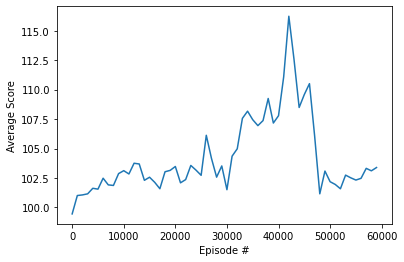

In [9]:
avg_scores = aggregate_list(trainer.scores, trainer_args["print_range"])
x = [i*trainer_args["print_range"] for i in range(len(avg_scores))]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(x, avg_scores)
plt.ylabel("Average Score")
plt.xlabel("Episode #")
plt.show()

### 4.3 Agent (Replay Memory) - Loss

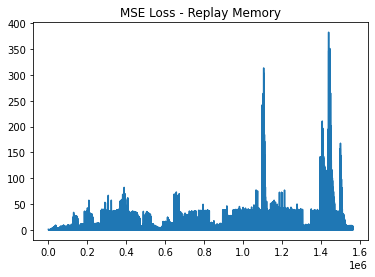

In [10]:
plt.plot(agent.losses)
plt.title("MSE Loss - Replay Memory")
plt.show()

### 4.2 Agent (Prioritized Memory) - Training

In [10]:
%%time

params.prioritized_memory = True
params.memory_size = 10000

agent = Agent(**params.dict())

# Add our custom prep_state function to the agent
agent.prep_state = custom_prep_state

trainer = Trainer(agent=agent, env=env, **trainer_args)
trainer.run(logs_callback=agent.logs, save_best_model=True, output_path="../models/DQN_PER_best_score.pt")

print(f"Episode: {trainer.last_episode} - Score: {trainer.best_score}")

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Episode 1000	Avg Score: 100.63	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 2000	Avg Score: 100.86	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 3000	Avg Score: 101.00	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 4000	Avg Score: 101.00	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 5000	Avg Score: 101.01	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 6000	Avg Score: 101.22	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 7000	Avg Score: 101.50	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 8000	Avg Score: 92.26	Epsilon: 0.01	Avg. MSE Loss: 1.00
Episode 9000	Avg Score: 101.46	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 10000	Avg Score: 101.66	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 11000	Avg Score: 101.14	Epsilon: 0.01	Avg. MSE Loss: 0.00
Episode 11877	Avg Score: 101.55	Epsilon: 0.01	Avg. MSE Loss: 0.00

### 4.2 Agent (Prioritized Memory) - Scores

In [ ]:
avg_scores = aggregate_list(trainer.scores, trainer_args["print_range"])
x = [i*trainer_args["print_range"] for i in range(len(avg_scores))]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(x, avg_scores)
plt.ylabel("Average Score")
plt.xlabel("Episode #")
plt.show()

### 4.2 Agent (Prioritized Memory) - Loss

In [ ]:
plt.plot(agent.losses)
plt.title("MSE Loss - Prioritized Memory")
plt.show()

## 5. Save agent

In [13]:
agent.save_model(params.model_dir)

## 6. Load agent

In [ ]:
del agent

In [8]:
agent = Agent(**params.dict())
agent.prep_state = custom_prep_state
agent.epsilon_enabled = False

agent.load_model(params.model_dir)

## 7. Test trained agent

In [9]:
env = flappy_bird_gym.make("FlappyBird-v0")
env.seed(seed)

for i in range(10):
    play_env(agent, env, fps=30, render=True)

Score: 150.00
Score: 114.00
Score: 137.00
Score: 137.00
Score: 119.00
Score: 121.00
Score: 120.00
Score: 109.00
Score: 151.00
Score: 114.00


## 8. Conclusions

The Deep Q-Network (DQN) algorithm is a powerful algorithm that can learn playing the Flappy Bird game.

We achieved reasonable results with the DQM algorithm after training the agent for 60,000 episodes.

Unfortunately, the prioritized replay memory (PER) takes a lot of time to train and we are not able to evaluate the DQN Agent with it.